In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/brain-mri-dataset.zip", 'r')
zip_ref.extractall("/content/dataset")
zip_ref.close()

In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import regularizers
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
train_path = './dataset/Training'

filepaths = []
labels = []

directories = os.listdir(train_path) # store list of disease types
for directory in directories:
    f_path = os.path.join(train_path, directory) # join filepath with tumor name to get full path
    filelists = os.listdir(f_path) # get all files in list in current f_path
    filepaths.extend([os.path.join(f_path, file) for file in filelists]) # in current f_path add all files in filelist of it
    labels.extend([directory] * len(filelists)) # add label to current directory, number of labels equal to len(filelists)

train_frame = pd.DataFrame({'filepaths': filepaths, 'label': labels})

In [ ]:
test_path = './dataset/Testing'

filepaths = []
labels = []

directories = os.listdir(test_path)
for directory in directories:
    f_path = os.path.join(test_path, directory)
    filelists = os.listdir(f_path)
    filepaths.extend([os.path.join(f_path, file) for file in filelists])
    labels.extend([directory] * len(filelists))

test_frame = pd.DataFrame({'filepaths': filepaths, 'label': labels})

In [ ]:
img_size = (224, 224)
batch_size = 16

tr_gen = ImageDataGenerator(
                            rescale=1./255,
                            rotation_range=5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            horizontal_flip=True
                            )

ts_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_accuracies = []
fold_losses = []

for fold, (train_index, val_index) in enumerate(kf.split(train_frame)):
    print(f"Fold {fold + 1}")

    train_df = train_frame.iloc[train_index]
    valid_df = train_frame.iloc[val_index]

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='label', target_size=img_size,
                                           class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

    valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='label', target_size=img_size,
                                           class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

    base_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

    model = Sequential([
        base_model,
        Flatten(),
        Dropout(rate=0.3),
        Dense(len(train_gen.class_indices), activation='softmax')
    ])

    model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(train_gen, validation_data=valid_gen, epochs=8, shuffle=True, verbose=1)

    fold_accuracies.append(history.history['val_accuracy'][-1])
    fold_losses.append(history.history['val_loss'][-1])

avg_accuracy = np.mean(fold_accuracies)
avg_loss = np.mean(fold_losses)

var_accuracy = np.var(fold_accuracies)
var_loss = np.var(fold_losses)

print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Variance in Accuracy: {var_accuracy:.4f}")
print(f"Average Loss: {avg_loss:.4f}")
print(f"Variance in Loss: {var_loss:.4f}")


Fold 1
Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
29084464/29084464 [==============================] - 1s 0us/step
Epoch 1/8
286/286 [==============================] - 163s 346ms/step - loss: 0.6510 - accuracy: 0.8558 - val_loss: 0.2380 - val_accuracy: 0.9248
Epoch 2/8
286/286 [==============================] - 85s 298ms/step - loss: 0.2424 - accuracy: 0.9337 - val_loss: 0.3205 - val_accuracy: 0.9029
Epoch 3/8
286/286 [==============================] - 86s 298ms/step - loss: 0.1851 - accuracy: 0.9464 - val_loss: 4.2392 - val_accuracy: 0.9003
Epoch 4/8
286/286 [==============================] - 85s 295ms/step - loss: 0.0915 - accuracy: 0.9705 - val_loss: 0.2148 - val_accuracy: 0.9668
Epoch 5/8
286/286 [==============================] - 85s 296ms/step - loss: 0.1710 - accuracy: 0.9678 - val_loss: 0.1234 - val_accuracy: 0.9738
Epoch 6/8
286/286 [==============================] - 85s 298ms/step - loss: 0.1211 - 

In [ ]:
full_train_gen = tr_gen.flow_from_dataframe(train_frame, x_col='filepaths', y_col='label', target_size=img_size,
                                            class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

base_model = tf.keras.applications.DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(len(full_train_gen.class_indices), activation='softmax')
])

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(full_train_gen, epochs=8, shuffle=True, verbose=1)

test_gen = ts_gen.flow_from_dataframe(test_frame, x_col='filepaths', y_col='label', target_size=img_size,
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

test_score = model.evaluate(test_gen, steps=len(test_gen), verbose=1)
test_loss, test_accuracy = test_score

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Found 5712 validated image filenames belonging to 4 classes.
Epoch 1/8
357/357 [==============================] - 153s 296ms/step - loss: 0.6872 - accuracy: 0.8533
Epoch 2/8
357/357 [==============================] - 103s 287ms/step - loss: 0.2298 - accuracy: 0.9329
Epoch 3/8
357/357 [==============================] - 105s 293ms/step - loss: 0.1716 - accuracy: 0.9522
Epoch 4/8
357/357 [==============================] - 105s 294ms/step - loss: 0.1536 - accuracy: 0.9629
Epoch 5/8
357/357 [==============================] - 103s 289ms/step - loss: 0.0887 - accuracy: 0.9715
Epoch 6/8
357/357 [==============================] - 105s 295ms/step - loss: 0.0987 - accuracy: 0.9736
Epoch 7/8
357/357 [==============================] - 102s 286ms/step - loss: 0.0470 - accuracy: 0.9862
Epoch 8/8
357/357 [==============================] - 104s 290ms/step - loss: 0.0422 - accuracy: 0.9865
Found 1311 validated image filenames belonging to 4 classes.
82/82 [==============================] - 10s 101ms/ste

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

Epochs = [i + 1 for i in range(len(train_acc))]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Training History', fontsize=16, y=1.02)

axes[0].plot(Epochs, train_loss, 'r', label='Training Loss')
axes[0].set_title('Training Loss', fontsize=18)
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].plot(Epochs, train_acc, 'r', label='Training Accuracy')
axes[1].set_title('Training Accuracy', fontsize=18)
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

82/82 [==============================] - 6s 53ms/step


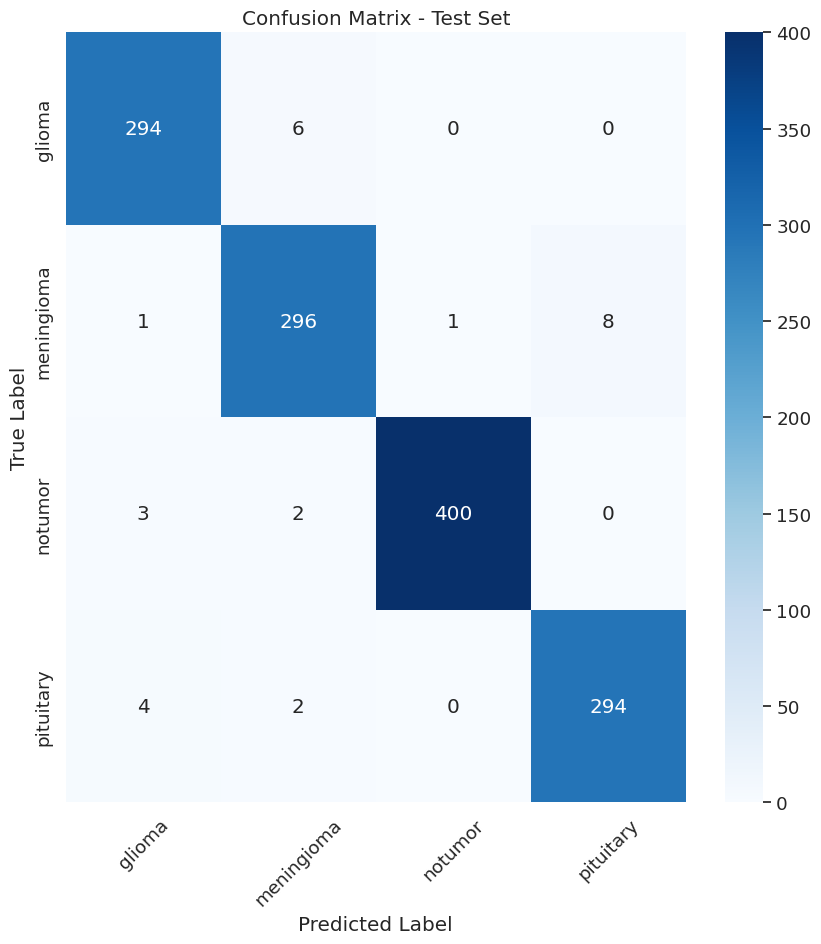

              precision    recall  f1-score   support

      glioma       0.97      0.98      0.98       300
  meningioma       0.97      0.97      0.97       306
     notumor       1.00      0.99      0.99       405
   pituitary       0.97      0.98      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [ ]:
test_preds = model.predict(test_gen, steps=len(test_gen), verbose=1)
test_y_pred = np.argmax(test_preds, axis=1)

test_cm = confusion_matrix(test_gen.classes, test_y_pred)
test_classes = list(test_gen.class_indices.keys())

plt.figure(figsize=(10, 10))
sns.set(font_scale=1.2)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_classes, yticklabels=test_classes)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.show()

print(classification_report(test_gen.classes, test_y_pred, target_names=test_classes))